<a href="https://colab.research.google.com/github/sutson/CE4145-Natural-Language-Processing-Coursework/blob/main/CE4145%20NLP%20-%20Binary%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CE4145 Natural Language Processing Coursework - Wilson Sutherland**

Disclaimer: Generative AI was used to support completion of this assessment. The GenAI tools Copilot and Gemini were used for the purpose of ideation and, in some cases, editing. Where used for the purpose of supporting development,
comments have been provided against relevant cells.

# 1. Dataset

## 1.1 Introduction

The *Game Reviews Sentiment* dataset is an assortment of text-based player reviews of a variety of video games. The sources of these reviews are not disclosed by the creator, however it is believed that they have been collated from various outlets such as Steam and Metacritic.

This coursework aims to perform text classification on this dataset. Each row in the dataset has a score, in 10 point increments from 0 to 100, as well as a category which converts ranges of these scores to **negative**, **mixed**, or **positive**:

| Review Category | Score Range (Inclusive) |
| --------------- | ----------- |
| negative        | 0  to 50    |
| mixed           | 60 to 70    |
| positive        | 80 to 100   |

Review Category and Review Score are both categorical, so we could use either as our label for classification. The [supplementary notebook](https://github.com/sutson/CE4145-Natural-Language-Processing-Coursework/blob/main/CE4145%20NLP%20-%20Multiclass%20Classification%20(Supplementary).ipynb) attempts multi-class analysis using the Review Score (11 classes) but found that the results were very poor. As the above table shows, the **mixed** category contains only two values and is quite ambiguous.

Therefore, a binary classification using the Review Category was investigated instead, considering only **positive** and **negative** reviews. This decision was justified on the basis of the experiments conducted which showed that middle-range review scores were often incorrectly classified, whereas low and high scores were predicted comparatively well.

## 1.2 Exploring the Dataset

In [1]:
# some imports which will be used later
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk

# set the filepath to from which files should be saved/loaded
# Google Drive needs to be mounted firstly
main_filepath = "drive/MyDrive/Colab Notebooks/CE4145 - Natural Language Processing/Coursework/data"

In [2]:
# load the dataset from Hugging Face
from datasets import load_dataset
ds = load_dataset("auphong2707/game-reviews-sentiment")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/688 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/30.5M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/30.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/629884 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/78735 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/78737 [00:00<?, ? examples/s]

In [4]:
# random state for reproducibility
random_state = 11037

# convert the train to pandas dataframe
df = ds["train"].to_pandas()

# print the size of the dataset and show first 10 rows
print(f"The dataset has {df.shape[0]} rows, and {df.shape[1]} columns")
df.head(10)

The dataset has 629884 rows, and 3 columns


,review_text,review_score,review_category
0,"I like LocoRoco 2 better than the first, the m...",100,positive
1,Need for Speed: World could have been a great ...,30,negative
2,Decent game but Fairly short Pretty hard Overp...,60,mixed
3,The game looks like a great game I have been w...,100,positive
4,This game is REALLY bad! Everything is out of ...,0,negative
5,Amazing game. Graphics are ungodly. Played on ...,100,positive
6,This game story took me back to the good final...,100,positive
7,As a MSQ enjoyer this is genuinely a 3/10 stor...,10,negative
8,Nice 16bit RPG with great battle system and de...,80,positive
9,This game is extremely difficult and frustrati...,30,negative


In [5]:
# check if there are any null values in the dataset
df.isnull().sum()

,0
review_text,0
review_score,0
review_category,0


In [6]:
# show number of instances of each review category
df.value_counts("review_category").sort_index(ascending=False)

,count
review_category,
positive,368669
negative,159847
mixed,101368


In [7]:
# number of "positive" instances
num_pos = df[df["review_category"] == "positive"].shape[0]
# number of "negative" instances
num_neg = df[df["review_category"] == "negative"].shape[0]
# number of "mixed" instances
num_mixed = df[df["review_category"] == "mixed"].shape[0]

# print percentages for each label
print(f"There are {num_pos} of {df.shape[0]} total reviews with a positive score, equivalent to {round(num_pos/df.shape[0],2)*100}%")
print(f"There are {num_neg} of {df.shape[0]} total reviews with a negative score, equivalent to {round(num_neg/df.shape[0],2)*100}%")
print(f"There are {num_mixed} of {df.shape[0]} total reviews with a mixed score, equivalent to {round(num_mixed/df.shape[0],2)*100}%")

There are 368669 of 629884 total reviews with a positive score, equivalent to 59.0%
There are 159847 of 629884 total reviews with a negative score, equivalent to 25.0%
There are 101368 of 629884 total reviews with a mixed score, equivalent to 16.0%


In [8]:
def class_dist_bar(inp_df, width=1):
  """
  class_dist_bar creates a simple class distribution bar plot based on an input dataframe.

  :param inp_df: dataframe to be considered
  :param width: width of bars in the plot
  """
  # get class counts and labels from dataframe
  counts = inp_df.value_counts("review_category").sort_index()
  labels = counts.index

  # create bar chart using class distribution data
  fig, ax = plt.subplots(figsize=(10, 6))
  ax.bar(labels, counts, tick_label=labels, width=width, color="purple")

  # define graph labels
  plt.xlabel("Review Category")
  plt.ylabel("Number of Reviews")
  plt.title("Review Category Distribution")
  plt.xticks(labels)

  plt.show()

def class_dist():
  """
  class_dist creates a simple class distribution pie chart based on an input dataframe.
  """
  plt.pie(df["review_category"].value_counts(), labels=df["review_category"].unique(), autopct='%1.1f%%')
  plt.title("Review Category Distribution")
  plt.show()

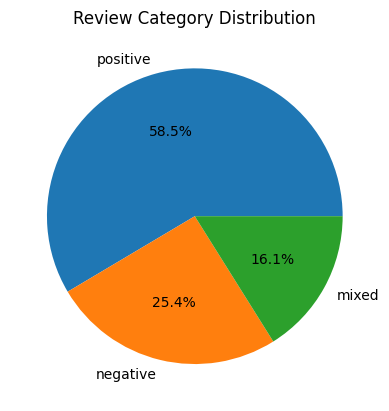

In [9]:
# show class distribution for review category as pie chart
class_dist()

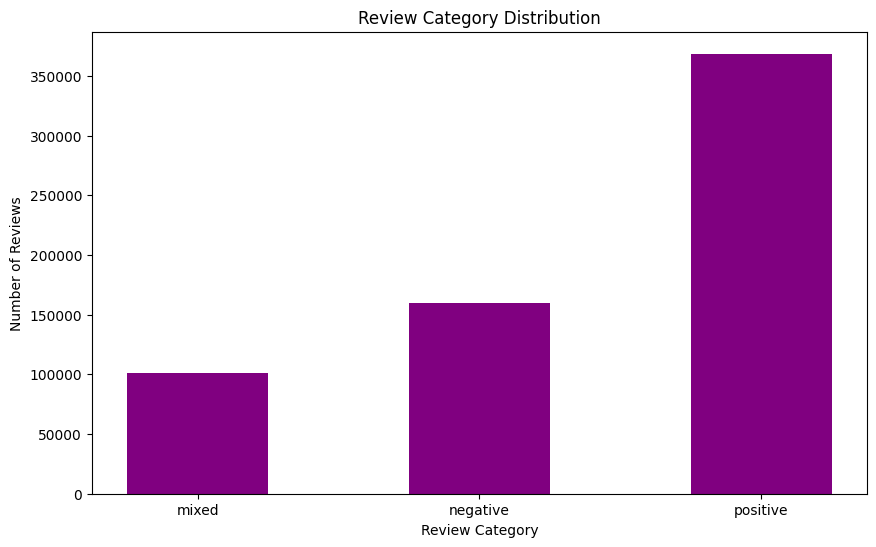

In [12]:
# show class distribution for review category as bar chart
class_dist_bar(df, 0.5)

## 1.3 Preprocessing the Dataset

### 1.3.1 Removing "Mixed" Reviews

In [13]:
"""
As mentioned in the introduction, "mixed" reviews prove difficult to model due to the ambigious nature of the dataset.
Therefore, we will only consider "positive" and "negative" reviews.
"""
# remove "mixed" reviews from the dataframe
df = df[df["review_category"] != "mixed"]
df.head(10)

,review_text,review_score,review_category
0,"I like LocoRoco 2 better than the first, the m...",100,positive
1,Need for Speed: World could have been a great ...,30,negative
3,The game looks like a great game I have been w...,100,positive
4,This game is REALLY bad! Everything is out of ...,0,negative
5,Amazing game. Graphics are ungodly. Played on ...,100,positive
6,This game story took me back to the good final...,100,positive
7,As a MSQ enjoyer this is genuinely a 3/10 stor...,10,negative
8,Nice 16bit RPG with great battle system and de...,80,positive
9,This game is extremely difficult and frustrati...,30,negative
10,This is a freaking **** 10 goes to all the hat...,100,positive


In [14]:
# display value counts to show only "positive" and "negative" reviews remain in the dataframe
df["review_category"].value_counts()

,count
review_category,
positive,368669
negative,159847


### 1.3.2 Addressing Class Imbalance

In [15]:
"""
From the class distribution, we can see the dataset is heavily imbalanced.
To resolve this, we will consider only 7,500 instances of each class instead of the entire dataset.
We could choose more, but 7,500 is a good compromise for computational time.
"""
# update the dataframe to sample 7,500 reviews for each class (review category)
df = df.sample(frac=1, random_state=random_state).groupby("review_category").head(7_500) # (Stack Overflow, 2023)

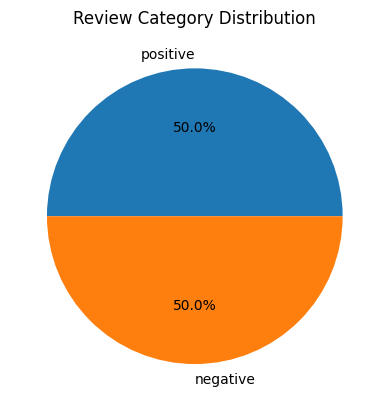

In [16]:
# show new class distribution as pie chart
class_dist()

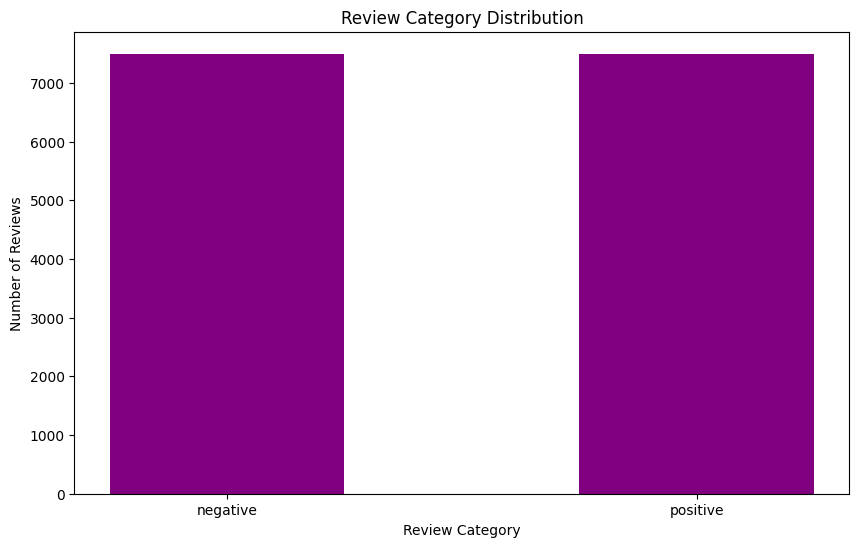

In [19]:
# show new class distribution as bar chart
class_dist_bar(df, 0.5)

### 1.3.3 Standardising the Text

In [20]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.9 MB/s eta 0:00:00


In [21]:
import re
import inflect
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# download the following for preprocessing steps
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("words")
words = set(nltk.corpus.words.words())

# create instance of inflect for preprocessing steps
p = inflect.engine()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [22]:
def perform_number_to_text_conversion(text):
  """
  perform_number_to_text_conversion converts numbers in a text to their text-based equivalents
  for example, "412" becomes "four hundred and twelve".
  This also accounts for cases like "ps3" - the 3 here will not be converted as it is part of an abbreviation.

  :param text: string to be converted
  """
  all_numbers = re.findall(r"(?:(?<=\s)|^)\d+(?:\.\d+)?(?=\s|$)", text) # find all numbers in text - GenAI used to edit regex string
  for number in all_numbers:
    try:
      text = text.replace(number, p.number_to_words(number)) # use inflect to convert each number to words
    except:
      text = text.replace(number, "")
  return text

def perform_contraction_resolution(text):
  """
  perform_contraction_extraction resolves contractions using the contractions package.

  :param text: string to be converted
  """
  return contractions.fix(text) # use contractions package

def perform_rating_conversion(text):
  """
  perform_rating_conversion replaces instances of rating with their text-based equivalent.
  For example, "4/10" becomes "4 out of 10".

  :param text: string to be converted
  """
  return re.sub(r"(\d+)\s*/\s*(\d+)", r"\1 out of \2", text) # GenAI used to edit regex string

def perform_punctuation_removal(text):
  """
  perform_punctuation_removal removes all punctuation from the input text.

  :param text: string to be converted
  """
  return re.sub(r"[^a-zA-Z0-9]+", " ", text)

def perform_censorship_conversion(text):
  """
  perform_censorship_conversion converts censored words (represented by multiple asterisks in a row) to "curseword".

  :param text: string to be converted
  """
  return re.sub(r"\*+", "curseword", text)

def perform_url_removal(text):
  """
  perform_url_removal removes any instances of URL strings in the text.
  It was found that some URLs in the dataset started with **** so these have to be removed as well.

  :param text: string to be converted
  """
  url_regex = re.compile(r"(?:https?://|\*\*\*\*)/\S+") # finds URLs starting with http://, https:// or ****/ - GenAI used to edit regex string

  return url_regex.sub("", text)

# create simple map from symbol to replacement text
symbol_dict = {
    "£": "pound",
    "$": "dollar",
    "¢": "cent",
    "€": "euro",
    "%": "percent",
    "&": "and",
    "@": "at"
}

def perform_common_symbol_conversion(text):
  """
  perform_common_symbol_conversion converts common symbols like "$" to text (i.e. "dollar").
  This changes "$10" to "10 dollar" and "@" to "at" as some people use these symbols in their reviews.

  :param text: string to be converted
  """
  # perform start of number symbol conversion (eg. "$10" -> "10 dollar")
  text = re.sub(
    r"([£$€])(\d+(?:\.\d+)?)", # GenAI used to edit regex string
    lambda m: f"{m.group(2)} {symbol_dict[m.group(1)]}",
    text
  )

  # perform end of number symbol conversion (eg. "10%" -> "10 percent")
  text = re.sub(
    r"(\d+(?:\.\d+)?)([¢%])", # GenAI used to edit regex string
    lambda m: f"{m.group(1)} {symbol_dict[m.group(2)]}",
    text
  )

  # perform conversion of "@" and "&"
  for symbol in ["@", "&"]:
    text = text.replace(symbol, f"{symbol_dict[symbol]}")

  return text.strip()

def perform_stop_word_removal(text):
  """
  perform_stop_word_removal removes stop words based on the nltk package
  This includes short words which provide no additional information like "is" and "a"

  :param text: string to be converted
  """
  sentence = text.split()
  return " ".join([word for word in sentence if word not in stopwords.words("english")])

def perform_stemming(text):
  """
  perform_stemming carries out the stemming procedure using the nltk package
  This truncates words to their root form, for example "playing" -> "play"

  :param text: string to be converted
  """
  stemmer = SnowballStemmer("english") # specify English stemming rules
  sentence = text.split()
  return " ".join([stemmer.stem(word) for word in sentence])

In [23]:
def preprocess(dframe):
  """
  preprocess carries out preprocessing steps to an input dataframe.

  :param dframe: dataframe to be preprocessed
  """
  dframe["review_text"] = dframe["review_text"].apply(lambda x: x.lower())
  dframe["review_text"] = dframe["review_text"].apply(perform_url_removal)
  dframe["review_text"] = dframe["review_text"].apply(perform_common_symbol_conversion)
  dframe["review_text"] = dframe["review_text"].apply(perform_censorship_conversion)
  dframe["review_text"] = dframe["review_text"].apply(perform_contraction_resolution)
  dframe["review_text"] = dframe["review_text"].apply(perform_rating_conversion)
  dframe["review_text"] = dframe["review_text"].apply(perform_punctuation_removal)
  dframe["review_text"] = dframe["review_text"].apply(perform_number_to_text_conversion)
  dframe["review_text"] = dframe["review_text"].apply(perform_stop_word_removal)
  dframe["review_text"] = dframe["review_text"].apply(perform_stemming)

  return dframe

In [24]:
# preprocess the dataframe and show the first 10 rows
df = preprocess(df)
df.head(10)

,review_text,review_score,review_category
355566,modern take two thousand twenty-thre game grea...,80,positive
489849,game dissapoint one surpris game ever play dea...,90,positive
111785,read syrik one hundr seventeen person agre bor...,0,negative
348841,game treat mordhau offer excel immers game pla...,100,positive
488318,beauti present game deep interest parti combin...,90,positive
128172,payday two use game incred fun fun mar incompe...,0,negative
70524,one campaign play yet hear realli great two zo...,40,negative
104497,evolut stylish action game date complet upgrad...,100,positive
373136,game absolut bleed style amaz beauti cel shade...,100,positive
304650,hate everyth game mechan everi develop think l...,10,negative


# 2. Representation Learning

This section implements Representation Learning to transform the text data into a suitable input format for the NLP algorithms. Three models are implemented and compared using a basic Logistic Regression algorithm:
- Word-2-Vector (Word2Vec)
- GloVe
- Document-2-Vector (Doc2Vec)

The results indicated that Doc2Vec would be the most suitable.

## 2.1 Introduction to Document-2-Vector (Doc2Vec)

Doc2Vec is essentially an extension of Word2Vec where full paragraphs (or sentences) are represented as vectors (GeeksforGeeks, 2025). Word2Vec only considers individual words for its representation, using Continuous Bag of Words or Skipgrams to use discrete tokens to predict the context. Doc2Vec is instead trained by considering the overall review data to provide a more comprehensive semantic analysis. As a result, it takes a lot longer to train.

This works by tokenising the text and assigning each document (review) a unique tag. The learner is then trained over multiple epochs which allows the embeddings to be learned (Van Otten, 2023). The default approach for training is Distributed Memory (PV-DM) which utilises both the unique document ID and the context for predictions, which is appropriate for our task of semantic analysis, despite being slower than its counterpart Distributed Bag of Words (PV-DBOW).

Ultimately, this is great for our task as it allows the semantic meaning of the entire review to be considered rather than predicting based on individual words and context.

## 2.2 Experimenting with Representation Learners

In [25]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 34.7 MB/s eta 0:00:00


In [26]:
"""
Here we define some functions which will be used later on.
"""
import json

def write_weights_to_file(filename, representation):
  """
  write_weights_to_file writes out a representation to a file so it can be loaded in without needing to create it again.
  This is useful for saving time and computational resources by not having to retrain the model every time the notebook is rerun.
  The default filepath, given by main_filepath, needs to be updated to the location where the file should be saved.

  :param filename: name of file to be written
  :param representation: representation to be written
  """
  with open(f"{main_filepath}/{filename}.txt", "w") as file:
    json.dump([arr.tolist() for arr in representation], file)

def read_weights_from_file(filename):
  """
  read_weights_from_file reads a representation from a file.
  This is useful in case the session crashes and saves computational resources by not having to retrain the model every time the notebook is rerun.
  The default filepath, given by main_filepath, needs to be updated to the location where the file is stored.

  :param filename: name of file to be read
  """
  with open(f"{main_filepath}/{filename}.txt", "r") as file:
    data = json.load(file)
  return data

def write_scores_to_file(filename, scores):
  """
  write_scores_to_file writes out the score data from a k-fold to a file so it can be loaded in without needing to create it again.
  This is useful for saving time and computational resources by not having to regenerate the scores every time the notebook is rerun.
  The default filepath, given by main_filepath, needs to be updated to the location where the file should be saved.

  :param filename: name of file to be written
  :param representation: scores to be written
  """
  with open(f"{main_filepath}/{filename}.txt", "w") as file:
    json.dump(scores, file)

def read_scores_from_file(filename):
  """
  read_scores_from_file reads score data for a k-fold run from a file.
  This is useful in case the session crashes and saves computational resources by not having to rerun the k-fold every time the notebook is rerun.
  The default filepath, given by main_filepath, needs to be updated to the location where the file is stored.

  :param filename: name of file to be read
  """
  with open(f"{main_filepath}/{filename}.txt", "r") as file:
    data = json.load(file)
  return data

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def create_confusion_matrix_plot(con_matrix, title, colour = "Blues"):
  """
  create_confusion_matrix_plot creates a single confusion matrix plot based on several inputs.

  :param con_matrix: confusion matrix to be plotted
  :param title: title of plot
  :param colour: colour palette to be used, defaults to Blues
  """
  # create heatmap which serves as the visual representation of the confusion matrix
  sns.heatmap(
    con_matrix,
    annot=True,
    fmt="d",
    cmap=colour,
    xticklabels=sorted(df["review_category"].unique()),
    yticklabels=sorted(df["review_category"].unique()),
  )

  # change plot attributes
  plt.title(f"\nConfusion Matrix - {title}\n")
  plt.xlabel("\nPredicted")
  plt.ylabel("True\n")
  plt.figure(figsize=(20,10))

  plt.tight_layout()
  plt.show()

def create_combined_confusion_matrix_plots(con_matrices, titles, colours, fig_width):
  """
  create_combined_confusion_matrix_plots creates a combined plot of several confusion matrix plot based on several inputs.

  :param con_matrices: confusion matrices to be plotted
  :param titles: array of titles of plots
  :param colour: array of colour palettes to be used for each individual plot
  :param fig_width: width of overall figure
  """
  # initialise subplots
  fig, axes = plt.subplots(1, len(con_matrices), figsize=(fig_width, 6))

  # loop over each confusion matrix and plot a heatmap for it
  for i, con_matrix in enumerate(con_matrices):
    sns.heatmap(
        con_matrix,
        annot=True,
        fmt="d",
        cmap=colours[i],
        ax=axes[i],
        yticklabels = df["review_category"].unique(),
        xticklabels = df["review_category"].unique(),
    )

    # set plot attributes
    axes[i].set_title("\n" + titles[i] + "\n")
    axes[i].set_xlabel("\nPredicted")
    axes[i].set_ylabel("True\n")

  plt.tight_layout()
  plt.show()

def create_bar_comparison(reports, title = ""):
  """
  create_bar_comparison creates a comparison plot for multiple classification reports.

  :param reports: classification reports to be plotted
  :param title: title of the plot
  """
  # define the metrics, these are the classification attributes
  metrics = ["accuracy", "precision", "recall", "f1-score"]

  # initialise plot
  plt.figure(figsize=(20, 10))
  ax = plt.gca()

  # define x_axis and width for separating the bars correctly
  x_axis = np.arange(len(metrics))
  width = 0.4 if len(reports) == 2 else 0.25

  max_val, min_val = 0, 1
  # loop over all classification reports and plot as a bar chart
  for i, report in enumerate(reports):
    attributes = [report["accuracy"], report["macro avg"]["precision"], report["macro avg"]["recall"], report["macro avg"]["f1-score"]]
    # determine the minimum and maximum values of the different attributes
    # this allows for the axis limit to be set which avoids showing unnecessary parts of the y-axis
    max_val_temp, min_val_temp = max(attributes), min(attributes)
    if max_val_temp > max_val:
      max_val = max_val_temp
    if min_val_temp < min_val:
      min_val = min_val_temp

    # plot bar chart
    plt.bar(
      x_axis + width*i,
      attributes,
      label=report["label"],
      color=report["colour"],
      width=width
    )

  # position x lables correctly
  plt.xticks(x_axis+(width if len(reports) == 3 else (width/2)), metrics)
  # set y-axis limits based on min and max values
  ax.set_ylim(min_val-0.02, max_val+0.02)

  plt.xlabel("\nMetric")
  plt.ylabel("Macro Average\n")
  plt.title(f"\nComparison of Macro Averages - {title}\n")

  plt.legend()
  plt.show()

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = np.array(df["review_text"]) # define independent features, i.e. review text
y = df["review_category"].values # define labels

# create train/test splits (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

### 2.2.1 Word-2-Vector (Word2Vec)

In [ ]:
from gensim.models import Word2Vec

def create_word2vec_rep(sentence, word2vec_model):
  """
  create_word2vec_rep generates a Word2Vec representation based on input text.

  :param sentence: sentence to be converted into the Word2Vec representation
  :param word2vec_model: Word2Vec model
  """
  embeddings = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv.index_to_key] # get word embeddings
  if embeddings:
    return np.mean(np.array(embeddings), 0) # return average of embeddings
  else:
    return np.zeros(word2vec_model.vector_size) # return zero vector with correct dimensions in case of some error to prevent dimensional mismatching

In [ ]:
# instantiate, build and train the Word2Vec model
word2vec_model = Word2Vec(vector_size=300, window=5, min_count=3, workers=4)
word2vec_model.build_vocab(X_train, update=None)
word2vec_model.train(corpus_iterable=X_train, total_examples=len(X_train), epochs=100)

# get the representation of the input data based on Word2Vec model we just trained
X_train_rep_word2vec = [create_word2vec_rep(instance, word2vec_model) for instance in X_train]
X_test_rep_word2vec = [create_word2vec_rep(instance, word2vec_model) for instance in X_test]

# write representations out to file for faster computation once it has been run once
write_weights_to_file("lr_word2vec_train", X_train_rep_word2vec)
write_weights_to_file("lr_word2vec_test", X_test_rep_word2vec)

# create basic Logistic Regression model to fit the data
model_lr_word2vec = LogisticRegression(max_iter=1000, random_state=random_state)
model_lr_word2vec.fit(X_train_rep_word2vec, y_train)

# predict outcomes based on model
y_pred_lr_word2vec = model_lr_word2vec.predict(X_test_rep_word2vec)

# show classification report to display metrics
print("\nLogistic Regression Model (Word2Vec):\n", classification_report(y_test, y_pred_lr_word2vec))


Logistic Regression Model (Word2Vec):
               precision    recall  f1-score   support

    negative       0.63      0.65      0.64      1506
    positive       0.64      0.62      0.63      1494

    accuracy                           0.64      3000
   macro avg       0.64      0.64      0.64      3000
weighted avg       0.64      0.64      0.64      3000



In [ ]:
"""
This cell reads the train and test representations for Word2Vec from a file, then implements the Logistic Regression model.
After the above representation has been created and the ouput written, comment out the above training cell and uncomment this one.
This is done because the model takes a long time to train so this saves some time.
"""
# X_train_rep_word2vec = read_weights_from_file("lr_word2vec_train")
# X_test_rep_word2vec = read_weights_from_file("lr_word2vec_test")

# model_lr_word2vec = LogisticRegression(max_iter=1000, random_state=random_state)
# model_lr_word2vec.fit(X_train_rep_word2vec, y_train)

# y_pred_lr_word2vec = model_lr_word2vec.predict(X_test_rep_word2vec)

# print("\nLogistic Regression Model (Word2Vec):\n", classification_report(y_test, y_pred_lr_word2vec))

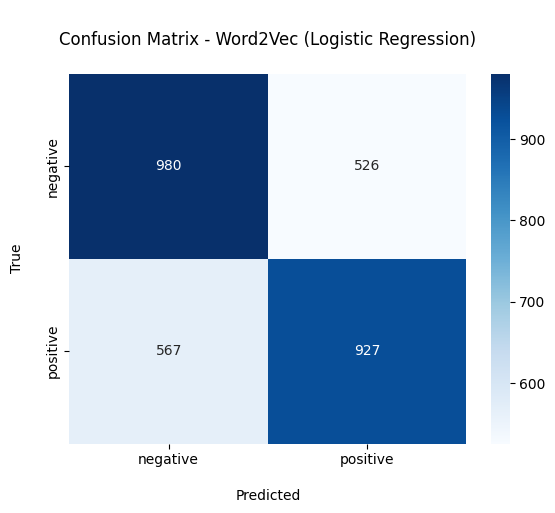

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# create confusion matrix based on Logistic Regression model and plot it
con_matrix_lr_word2vec = confusion_matrix(y_test, y_pred_lr_word2vec)
create_confusion_matrix_plot(con_matrix_lr_word2vec, "Word2Vec (Logistic Regression)")

### 2.2.2 GloVe

In [ ]:
"""
To work with GloVe, download the glove.6B.zip file from https://nlp.stanford.edu/projects/glove/
Extract the zip file and put the glove.6B.100d.txt file in the main_filepath directory.
The following code should be uncommented and run to generated the Word2Vec format required by gensim.
"""
# glove2word2vec(glove_input_file, word2vec_output_file)

In [ ]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# load the GloVe vectors from file to save computing time
glove_input_file = f"{main_filepath}/glove.6B.100d.txt"
word2vec_output_file = f"{main_filepath}/glove.6B.100d.word2vec.txt"

glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [ ]:
def create_glove_rep(sentence, glove_model):
  """
  create_glove_rep generates a GloVe representation based on input text.

  :param sentence: sentence to be converted into the GloVe representation
  :param glove_model: GloVe model
  """
  embeddings = [glove_model[word] for word in sentence if word in glove_model] # get word embeddings, similar to Word2Vec
  if embeddings:
    return np.mean(np.array(embeddings), 0) # return average of embeddings
  else:
    return np.zeros(glove_model.vector_size) # return zero vector with correct dimensions in case of some error to prevent dimensional mismatching

In [ ]:
# get the representation of the input data based on GloVe model
X_train_rep_glove = [create_glove_rep(instance, glove_model) for instance in X_train]
X_test_rep_glove = [create_glove_rep(instance, glove_model) for instance in X_test]

# write representations out to file for faster computation once it has been run once
write_weights_to_file("lr_glove_train", X_train_rep_glove)
write_weights_to_file("lr_glove_test", X_test_rep_glove)

# create basic Logistic Regression model to fit the data
model_lr_glove = LogisticRegression(max_iter=1000, random_state=random_state)
model_lr_glove.fit(X_train_rep_glove, y_train)

# predict outcomes based on model
y_pred_lr_glove = model_lr_glove.predict(X_test_rep_glove)

# show classification report to display metrics
print("\nLogistic Regression Model (GloVe):\n", classification_report(y_test, y_pred_lr_glove))


Logistic Regression Model (GloVe):
               precision    recall  f1-score   support

    negative       0.64      0.65      0.65      1506
    positive       0.64      0.64      0.64      1494

    accuracy                           0.64      3000
   macro avg       0.64      0.64      0.64      3000
weighted avg       0.64      0.64      0.64      3000



In [ ]:
"""
This cell reads the train and test representations for GloVe from a file, then implements the Logistic Regression model.
After the above representation has been created and the ouput written, comment out the above training cell and uncomment this one.
This is done because the model takes a long time to train so this saves some time.
"""
# X_train_rep_glove = read_weights_from_file("lr_glove_train")
# X_test_rep_glove = read_weights_from_file("lr_glove_test")

# model_lr_glove = LogisticRegression(max_iter=1000, random_state=random_state)
# model_lr_glove.fit(X_train_rep_glove, y_train)

# y_pred_lr_glove = model_lr_glove.predict(X_test_rep_glove)

# print("\nLogistic Regression Model (GloVe):\n", classification_report(y_test, y_pred_lr_glove))

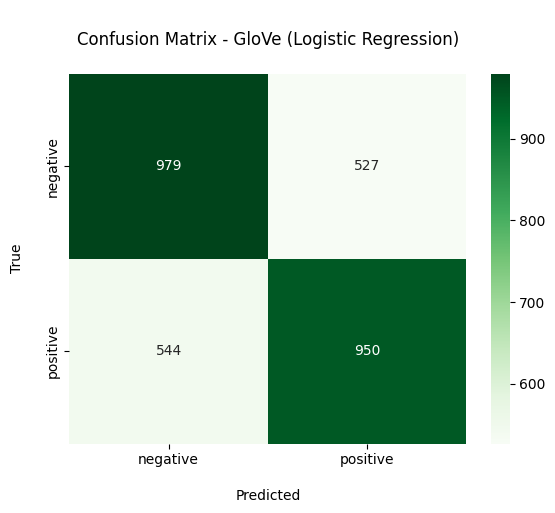

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# create confusion matrix based on Logistic Regression model and plot it
con_matrix_lr_glove = confusion_matrix(y_test, y_pred_lr_glove)
create_confusion_matrix_plot(con_matrix_lr_glove, "GloVe (Logistic Regression)", "Greens")

### 2.2.3 Document-2-Vector (Doc2Vec)

In [ ]:
from gensim.models.doc2vec import TaggedDocument

def create_doc2vec_rep(data):
  """
  create_doc2vec_rep generates a Doc2Vec representation based on input data.
  The data is converted into TaggedDocument objects, each of which is a list of words
  with a unique tag which lets us train the Doc2Vec model.

  :param data: text data to be converted into the Doc2Vec representation
  """
  return [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(data)] # (Mhaske, 2025)

# Apply the tagging function to training and testing data
def create_corpora(X_train, X_test):
  """
  create_corpora generates the train and test corpora based on the Doc2Vec representation.

  :param X_train: train text data
  :param X_test: test text data
  """
  train_corpus = create_doc2vec_rep(X_train)
  test_corpus = create_doc2vec_rep(X_test)
  return train_corpus, test_corpus

In [ ]:
from gensim.models.doc2vec import Doc2Vec

# generate train and test corpora
train_corpus, test_corpus = create_corpora(X_train, X_test)

# instantiate, build and train the Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=300, window=5, min_count=3, workers=4, epochs=100)
doc2vec_model.build_vocab(train_corpus)
doc2vec_model.train(train_corpus, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# get the representation of the input data based on Doc2Vec model we just trained
X_train_rep_doc2vec = [doc2vec_model.infer_vector(doc.words) for doc in train_corpus]
X_test_rep_doc2vec = [doc2vec_model.infer_vector(doc.words) for doc in test_corpus]

# write representations out to file for faster computation once it has been run once
write_weights_to_file("lr_doc2vec_train", X_train_rep_doc2vec)
write_weights_to_file("lr_doc2vec_test", X_test_rep_doc2vec)

# create basic Logistic Regression model to fit the data
model_lr_doc2vec = LogisticRegression(max_iter=1000, random_state=random_state)
model_lr_doc2vec.fit(X_train_rep_doc2vec, y_train)

# predict outcomes based on model
y_pred_lr_doc2vec = model_lr_doc2vec.predict(X_test_rep_doc2vec)

# show classification report to display metrics
print("\nLogistic Regression Model (Doc2Vec):\n", classification_report(y_test, y_pred_lr_doc2vec))


Logistic Regression Model (Doc2Vec):
               precision    recall  f1-score   support

    negative       0.87      0.88      0.87      1506
    positive       0.88      0.87      0.87      1494

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



In [30]:
"""
This cell reads the train and test representations for Doc2Vec from a file, then implements the Logistic Regression model.
After the above representation has been created and the ouput written, comment out the above training cell and uncomment this one.
This is done because the model takes a long time to train so this saves some time.
"""
# X_train_rep_doc2vec = read_weights_from_file("lr_doc2vec_train")
# X_test_rep_doc2vec = read_weights_from_file("lr_doc2vec_test")

# model_lr_doc2vec = LogisticRegression(max_iter=1000, random_state=random_state)
# model_lr_doc2vec.fit(X_train_rep_doc2vec, y_train)

# y_pred_lr_doc2vec = model_lr_doc2vec.predict(X_test_rep_doc2vec)

# print("\nLogistic Regression Model (Doc2Vec):\n", classification_report(y_test, y_pred_lr_doc2vec))

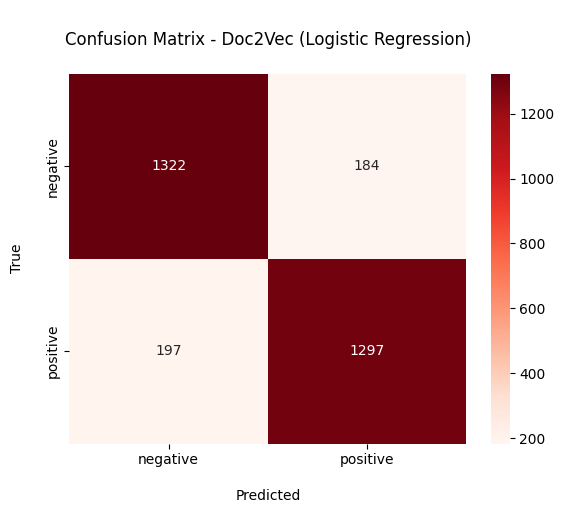

<Figure size 2000x1000 with 0 Axes>

In [31]:
# create confusion matrix based on Logistic Regression model and plot it
con_matrix_lr_doc2vec = confusion_matrix(y_test, y_pred_lr_doc2vec)
create_confusion_matrix_plot(con_matrix_lr_doc2vec, "Doc2Vec (Logistic Regression)", "Reds")

### 2.2.4 Comparison of the Three Representation Learners

In [ ]:
# print metrics for all representations to compare
print("\nLogistic Regression Model (Word2Vec):\n", classification_report(y_test, y_pred_lr_word2vec))
print("\nLogistic Regression Model (GloVe):\n", classification_report(y_test, y_pred_lr_glove))
print("\nLogistic Regression Model (Doc2Vec):\n", classification_report(y_test, y_pred_lr_doc2vec))


Logistic Regression Model (Word2Vec):
               precision    recall  f1-score   support

    negative       0.63      0.65      0.64      1506
    positive       0.64      0.62      0.63      1494

    accuracy                           0.64      3000
   macro avg       0.64      0.64      0.64      3000
weighted avg       0.64      0.64      0.64      3000


Logistic Regression Model (GloVe):
               precision    recall  f1-score   support

    negative       0.64      0.65      0.65      1506
    positive       0.64      0.64      0.64      1494

    accuracy                           0.64      3000
   macro avg       0.64      0.64      0.64      3000
weighted avg       0.64      0.64      0.64      3000


Logistic Regression Model (Doc2Vec):
               precision    recall  f1-score   support

    negative       0.87      0.88      0.87      1506
    positive       0.88      0.87      0.87      1494

    accuracy                           0.87      3000
   macro avg

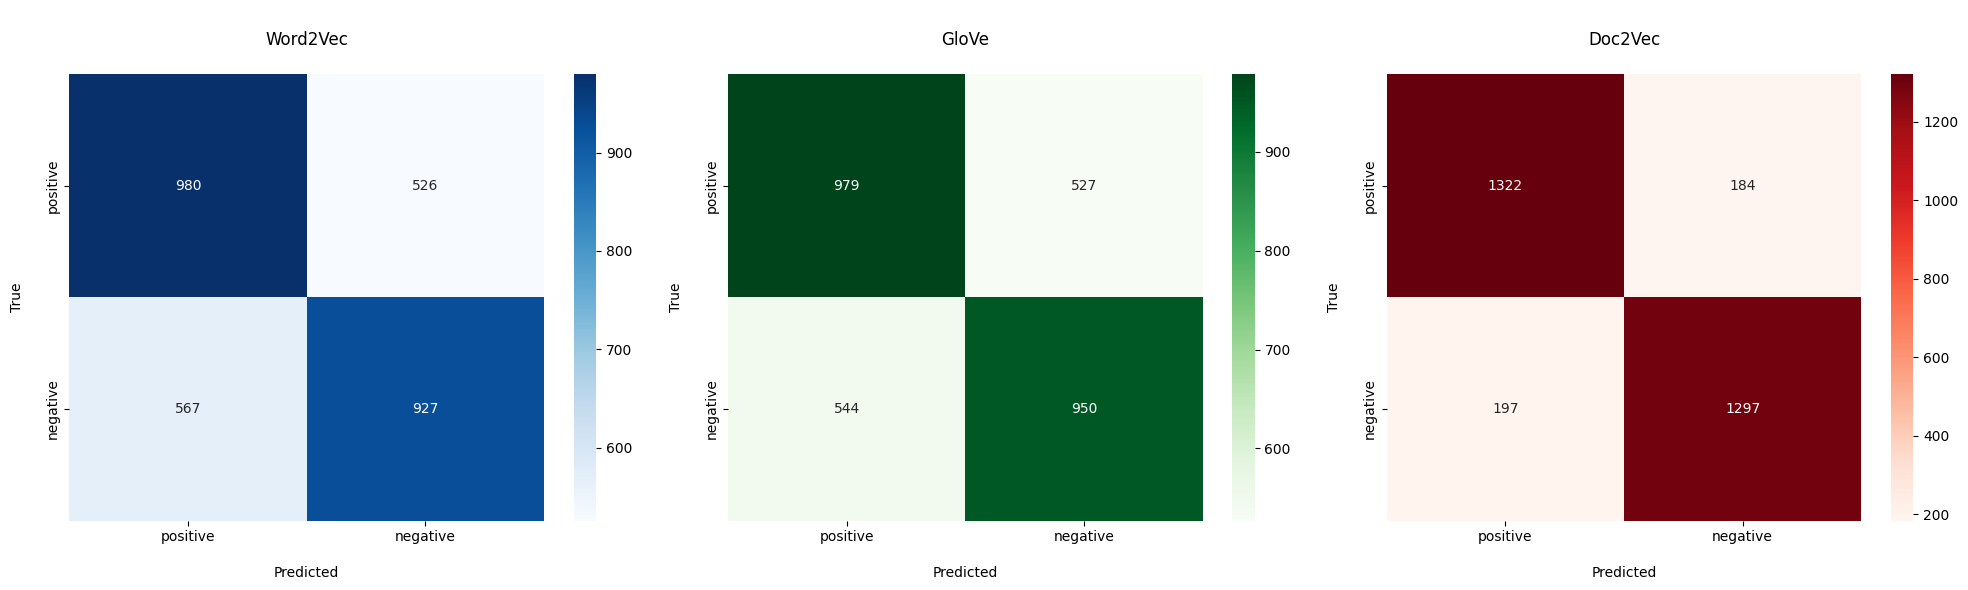

In [ ]:
# plot combined confusion matrices to compare the results
create_combined_confusion_matrix_plots(
  [con_matrix_lr_word2vec, con_matrix_lr_glove, con_matrix_lr_doc2vec],
  ["Word2Vec", "GloVe", "Doc2Vec"],
  ["Blues", "Greens", "Reds"],
  20
)

Word2Vec and GloVe produce similar accuracy results, whereas Doc2Vec performs significantly better, giving an accuracy of 87% and f1-score of 0.87.

# 3. Algorithms

## 3.1 Supper Vector Machine (SVM)

Support Vector Machine (SVM) is a supervised learning algorithm which works by evaluating the optimal *hyperplane* that best divides data points into its respective classes (MathWorks, no date). As such, it is a great choice for regression and classification tasks such as this.

An SVM's objective is to find the hyperplane which maximises the distance between the nearest data points to it from the different classes in the domain. These data points are called *support vectors*, and determine the best hyperplane configuration, ultimately helping to improve the accuracy of the classification.

For our problem in particular, SVMs are ideal as they work especially well with complex and abundant input features (Haj, 2025). Since we have decided to use Doc2Vec embeddings, which are large vector representations of the textual data, these can be reliably fed into the algorithm to produce a suitable result.

## 3.2 Multilayer Perceptron (MLP)

Multilayer Perceptron (MLP) is a neural network-based algorithm which consists of layers which are fully connected, meaning each node in a layer is linked to those in the previous one (Jaiswal, 2025). These usually consist of an input layer, at least one "hidden" layer, followed by an output layer.

The hidden layers are composed of several nodes whose purpose is to take input data, use weights and biases to process it, and utilise an *activation function* (typically ReLU) to create an output which is then consumed by the nodes in the next layer. This process continues until a final output is generated at the end of the tree.

MLPs learn by the process of *backpropagation*. Once an output is established, the difference between the predicted and true value, given by the loss function, is evaluated. The network then attempts to minimise this loss by iteratively recalculating the weights at each node.

This algorithm is appropriate for our classification problem as they are very adept at learning based on complex vector representations, such as ones created using Doc2Vec.

### 3.2.1 Implementation of the Algorithms

In [ ]:
import numpy as np
from tensorflow import keras
from keras import layers, activations
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# initialise arrays to store classification reports
svm_scores = []
mlp_scores = []

# convert labels to numerical values (0 or 1) to ensure compatibility with MLP model
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

# instantiate k-fold which random_state to ensure reproducibility
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# train and test the model for each k-fold
for fold_number, (train, test) in enumerate(kf.split(X, y_numeric)):
  X_train, X_test, y_train, y_test = X[train], X[test], y_numeric[train], y_numeric[test]

  # create train and test corpora
  train_corpus = create_doc2vec_rep(X_train)
  test_corpus = create_doc2vec_rep(X_test)

  # instantiate, build and train the Doc2Vec model
  doc2vec_model = Doc2Vec(vector_size=300, window=5, min_count=3, workers=4, epochs=100)
  doc2vec_model.build_vocab(train_corpus)
  doc2vec_model.train(train_corpus, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

  # get the representation of the input data based on Doc2Vec model we just trained
  X_train_rep_doc2vec = np.array([doc2vec_model.infer_vector(doc.words) for doc in train_corpus])
  X_test_rep_doc2vec = np.array([doc2vec_model.infer_vector(doc.words) for doc in test_corpus])

  # write representations out to file for faster computation once it has been run once
  write_weights_to_file(f"doc2vec_train_fold_{fold_number + 1}", X_train_rep_doc2vec)
  write_weights_to_file(f"doc2vec_test_fold_{fold_number + 1}", X_test_rep_doc2vec)

  """
  These two lines can be uncommented once this cell has been run once.
  These read the weights generated by each k-fold cross validation run once they have been written to file.
  If using these files, the above should be commented out from train_corpus and test_corpus onwards.
  """
  # X_train_rep_doc2vec = np.array(read_weights_from_file(f"doc2vec_train_fold_{fold_number + 1}"))
  # X_test_rep_doc2vec = np.array(read_weights_from_file(f"doc2vec_test_fold_{fold_number + 1}"))

  # --- SVC Model ---
  model_svc = SVC(kernel="linear", random_state=random_state) # create model
  model_svc.fit(X_train_rep_doc2vec, y_train) # fit with train representation
  y_pred_svc = model_svc.predict(X_test_rep_doc2vec) # predict outcomes
  svm_scores.append(classification_report(y_test, y_pred_svc, output_dict=True)) # append classification report to scores array

  # --- MLP Model ---
  model_mlp = keras.Sequential([
      keras.Input(shape=(300,)),
      keras.layers.Dense(128, activations.relu),
      keras.layers.Dense(64, activations.relu),
      keras.layers.Dense(2, activations.softmax) # two neurons for binary classification
  ])
  model_mlp.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) # use standard optimiser and loss

  # MLP requires one-hot encoding
  y_train_one_hot = to_categorical(y_train, num_classes=2)
  y_test_one_hot = to_categorical(y_test, num_classes=2)

  model_mlp.fit(X_train_rep_doc2vec, y_train_one_hot, batch_size=64, epochs=10, verbose=0) # fit with train representration
  y_pred_mlp = np.argmax(model_mlp.predict(X_test_rep_doc2vec), axis=1) # predict outcomes - GenAI used to edit model prediction code to work with classification report
  mlp_scores.append(classification_report(y_test, y_pred_mlp, output_dict=True)) # append classification report to scores array

# write out scores to file
write_scores_to_file("svm_scores", svm_scores)
write_scores_to_file("mlp_scores", mlp_scores)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# get macro average scores from classification reports for each run
acc_scores_svc = [score["macro avg"]["recall"] for score in svm_scores]
acc_scores_mlp = [score["macro avg"]["recall"] for score in mlp_scores]

def get_accuracy_results(acc_scores, model_name):
  """
  get_accuracy_results prints out accuracy values for each fold based on model performances.

  :param acc_scores: array of accuracy scores
  :param model_name: name of the model for showing in the output
  """
  print(f"{model_name} Model - Accuracy for each run:")
  for i in range(len(acc_scores)):
    print(f"Fold {i + 1}: {round(acc_scores[i], 3)}%")

  macro_avg_score = sum(acc_scores) / len(acc_scores)
  print(f"\nAverage accuracy across 5 folds: {round(macro_avg_score, 3)}%")

# print accuracy results comparison
get_accuracy_results(acc_scores_svc, "SVC")
print("\n---------\n")
get_accuracy_results(acc_scores_mlp, "MLP")

SVC Model - Accuracy for each run:
Fold 1: 0.869%
Fold 2: 0.866%
Fold 3: 0.862%
Fold 4: 0.861%
Fold 5: 0.871%

Average accuracy across 5 folds: 0.866%

---------

MLP Model - Accuracy for each run:
Fold 1: 0.843%
Fold 2: 0.844%
Fold 3: 0.84%
Fold 4: 0.842%
Fold 5: 0.849%

Average accuracy across 5 folds: 0.843%


### 3.2.2 Improving Performance

As we can see, Support Vector Machine performs better than Multilayer Perceptron with our representations.

We could improve the model by testing various combinations of hyper parameters to find which produce the best results. We will use `random_search` which is less effective than `GridSearchCV` but takes much less time. `GridSearchCV` tries every possible combination of parameters so we cannot reliably use this method unless we have more computing power (Hestisholihah, 2023).

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# --- Baseline SVC Model ---
model_svc = SVC(kernel="linear", random_state=random_state) # create model
model_svc.fit(X_train_rep_doc2vec, y_train) # fit with train representation
y_pred_svc_base = model_svc.predict(X_test_rep_doc2vec) # predict outcomes

# --- SVC Model Using Random Search ---
# set up the pipeline - GenAI used for ideas as to how to set up the SVC pipeline
svc_pipeline = Pipeline([
  ("scaler", StandardScaler()),
  ("svc", SVC())
])

# instantiate parameter distributions to be used by random search - GenAI used for ideas for hyper parameters
param_distributions = {
  "svc__C": np.logspace(-2, 2, 10), # uniform distribution between 0.01 and 100
  "svc__gamma": np.logspace(-3, 1, 10), # uniform distribution between 0.001 and 10
  "svc__kernel": ["rbf", "linear"]
}

# set up random search
random_search = RandomizedSearchCV(
  svc_pipeline, # use the pipeline created above
  param_distributions=param_distributions,
  n_iter=10, # try 10 random combinations
  cv=3, # iterate over 3 folds, more would be very computationally intensive
  n_jobs=-1,
  scoring="f1_macro",
  random_state=random_state # ensure reproducibility
)

# fit and use best estimator to predict outcomes
random_search.fit(X_train_rep_doc2vec, y_train)
y_pred_svc_best = random_search.best_estimator_.predict(X_test_rep_doc2vec)

# show best parameters based on random search
print("Best parameters for SVC model:", random_search.best_params_)

# write out scores to file
write_scores_to_file("svm_best_params", random_search.best_params_)
write_scores_to_file("svm_best_score", classification_report(y_test, y_pred_svc_best))

Best parameters: {'svc__kernel': 'linear', 'svc__gamma': np.float64(0.0027825594022071257), 'svc__C': np.float64(0.01)}

SVC Best Model:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87      1500
           1       0.87      0.87      0.87      1500

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



In [ ]:
# show classification reports
svc_base_report = classification_report(y_test, y_pred_svc_base, output_dict=True)
svc_best_report = classification_report(y_test, y_pred_svc_best, output_dict=True)

print("\nSVC Base Model:\n", classification_report(y_test, y_pred_svc_base))
print("\nSVC Best Model:\n", classification_report(y_test, y_pred_svc_best))


SVC Base Model:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87      1500
           1       0.87      0.87      0.87      1500

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000


SVC Best Model:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87      1500
           1       0.87      0.87      0.87      1500

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



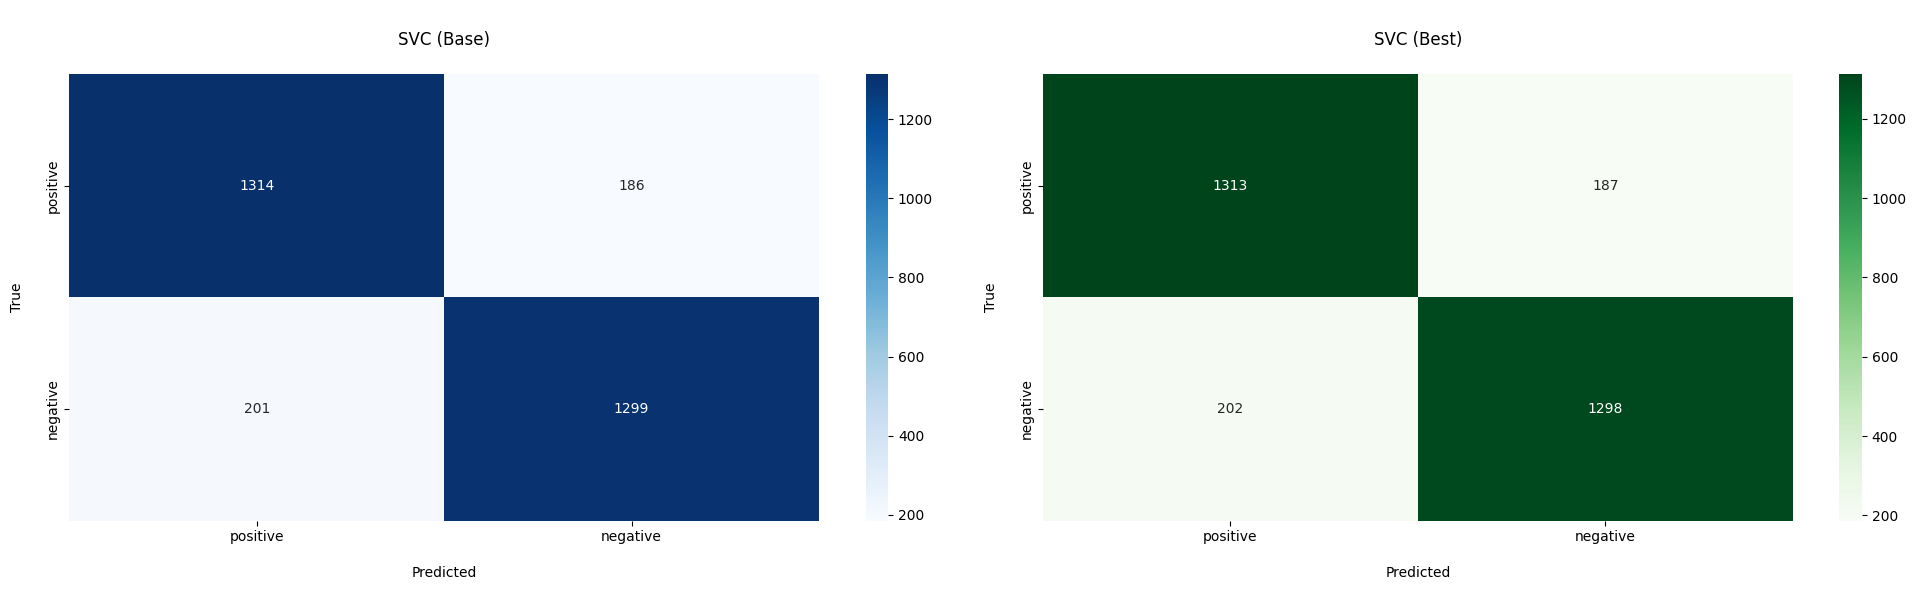

In [ ]:
# create confusion matrices
con_matrix_svc_base = confusion_matrix(y_test, y_pred_svc_base)
con_matrix_svc_best = confusion_matrix(y_test, y_pred_svc_best)

# plot combined confusion matrices to compare the results
create_combined_confusion_matrix_plots(
  [con_matrix_svc_base, con_matrix_svc_best],
  ["SVC (Base)", "SVC (Best)"],
  ["Blues", "Greens"],
  20
)

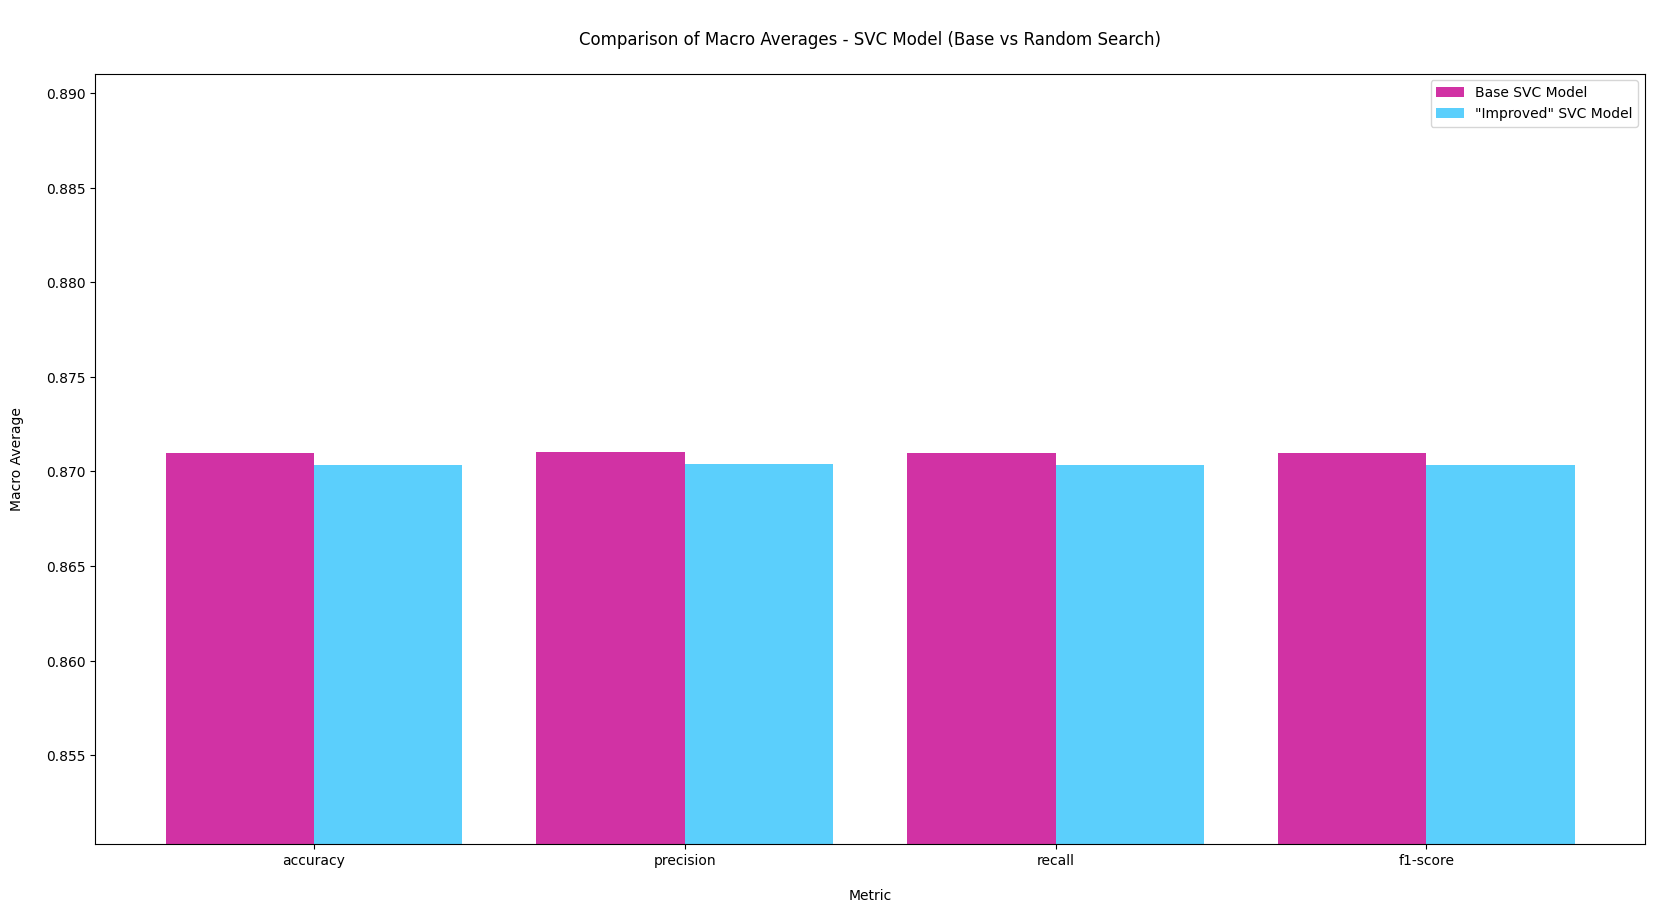

In [ ]:
# update classification report to have appropriate labels/colours
svc_base_report["label"] = "Base SVC Model"
svc_base_report["colour"] = "#d132a4"

svc_best_report["label"] = "\"Improved\" SVC Model"
svc_best_report["colour"] = "#5bcffc"

# plot bar chart to compare metrics
create_bar_comparison([svc_base_report, svc_best_report], "SVC Model (Base vs. Random Search)")

Despite using Random Search to improve the model, the accuracy metrics actually became slightly worse.

# 4. Evaluation

The results showed that Doc2Vec was significantly better at representing the data than Word2Vec and GloVe embeddings, improving accuracy on a basic Logistic Regression model by over 20%. These representations were then used to compare two NLP algorithms, namely Support Vector Machine (SVM) and Multilayer Perceptron (MLP). The SVM model performed better overall, as shown by the plots below and various metrics displayed in the previous section.

It was found that using Random Search to improve the model proved unsuccessful. This makes sense as it chooses a set of random parameters so may not be able to find a better solution than the baseline, especially when the number of combinations is limited. If more computational power was available, `GridSearchCV` could be used to find better hyper parameters to improve predictions.

It's very challenging to classify textual data, especially those coming from unofficial sources, as context is critical in determining the writer's true feelings. The preprocessing step is crucial, as we want to clean the data as much as possible for modelling, but this is never completely possible. We are essentially sculpting a new set of data which may inadvertently lose key information and be detrimental to algorithmic performance.

Future work on this dataset could examine different algorithms, forms of preprocessing and representation learners, or even determine the feasibility of predicting middle-range score reviews. However, this report ultimately serves as a comprehensive baseline investigation.

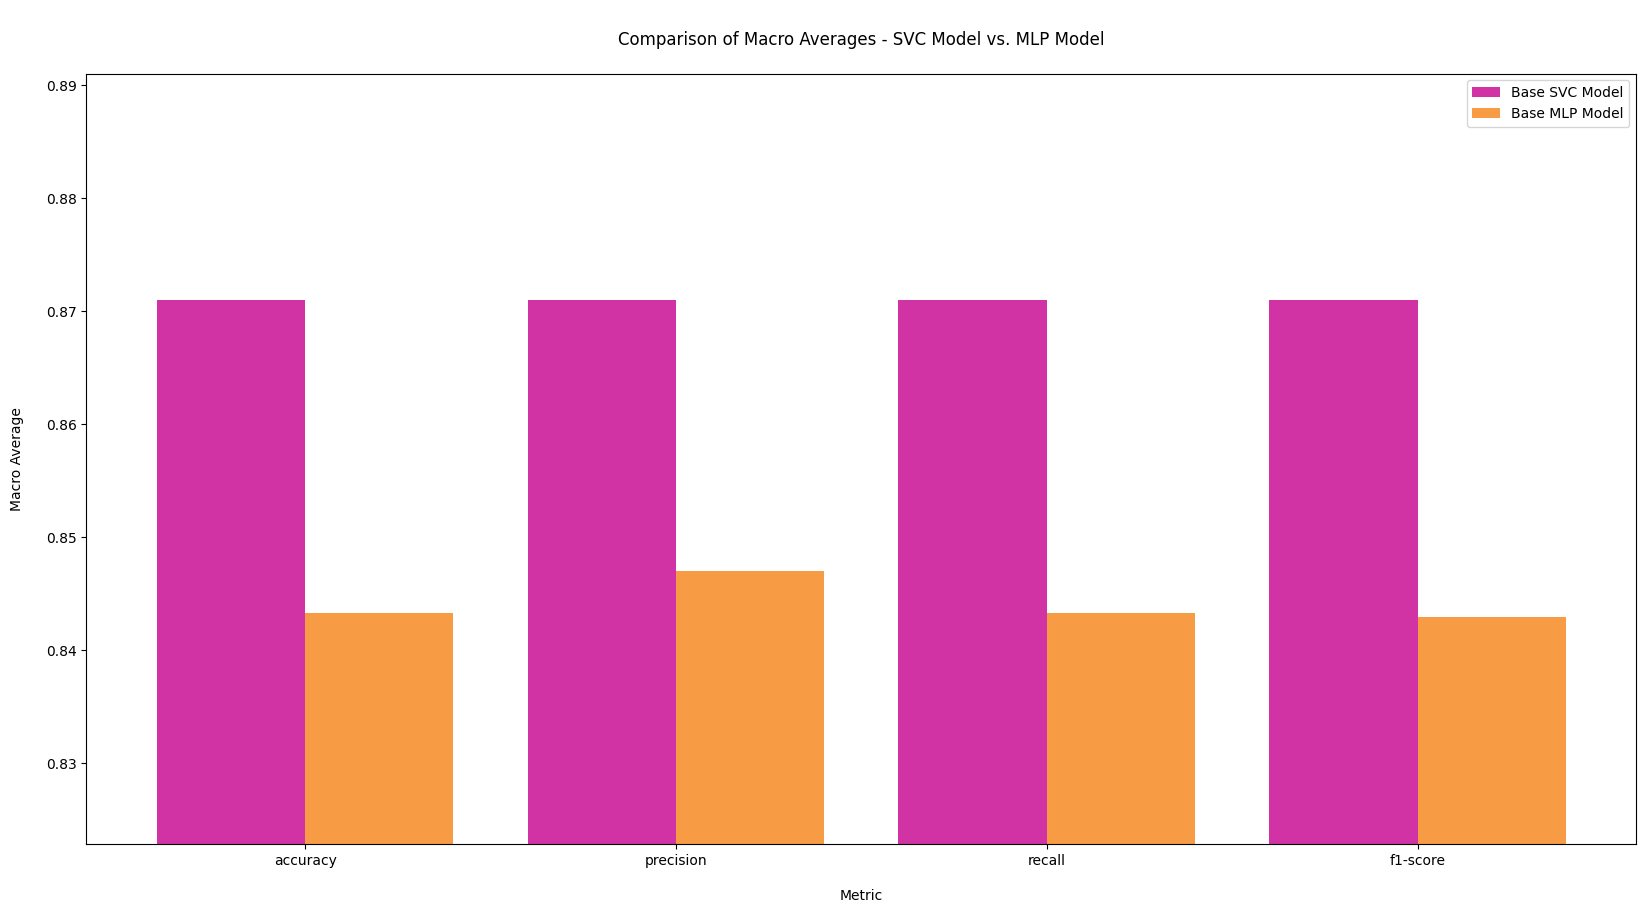

In [ ]:
# read MLP classification report from file
mlp_base_report = read_scores_from_file("mlp_scores")[0]

# update classification report to have appropriate labels/colours
mlp_base_report["label"] = "Base MLP Model"
mlp_base_report["colour"] = "#f79b45"

# plot bar chart to compare metrics
create_bar_comparison([svc_base_report, mlp_base_report], "SVC Model vs. MLP Model")

In [ ]:
# create example MLP model for comparison with SVM
model_mlp_eval = keras.Sequential([
  keras.Input(shape=(300,)),
  keras.layers.Dense(128, activations.relu),
  keras.layers.Dense(64, activations.relu),
  keras.layers.Dense(2, activations.softmax) # two neurons for binary classification
])
model_mlp_eval.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) # use standard optimiser and loss

y_train_one_hot = to_categorical(y_train, num_classes=2)
y_test_one_hot = to_categorical(y_test, num_classes=2)

model_mlp_eval.fit(X_train_rep_doc2vec, y_train_one_hot, batch_size=64, epochs=10, verbose=0) # fit with train representration
y_pred_mlp_eval = np.argmax(model_mlp_eval.predict(X_test_rep_doc2vec), axis=1) # predict outcomes

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


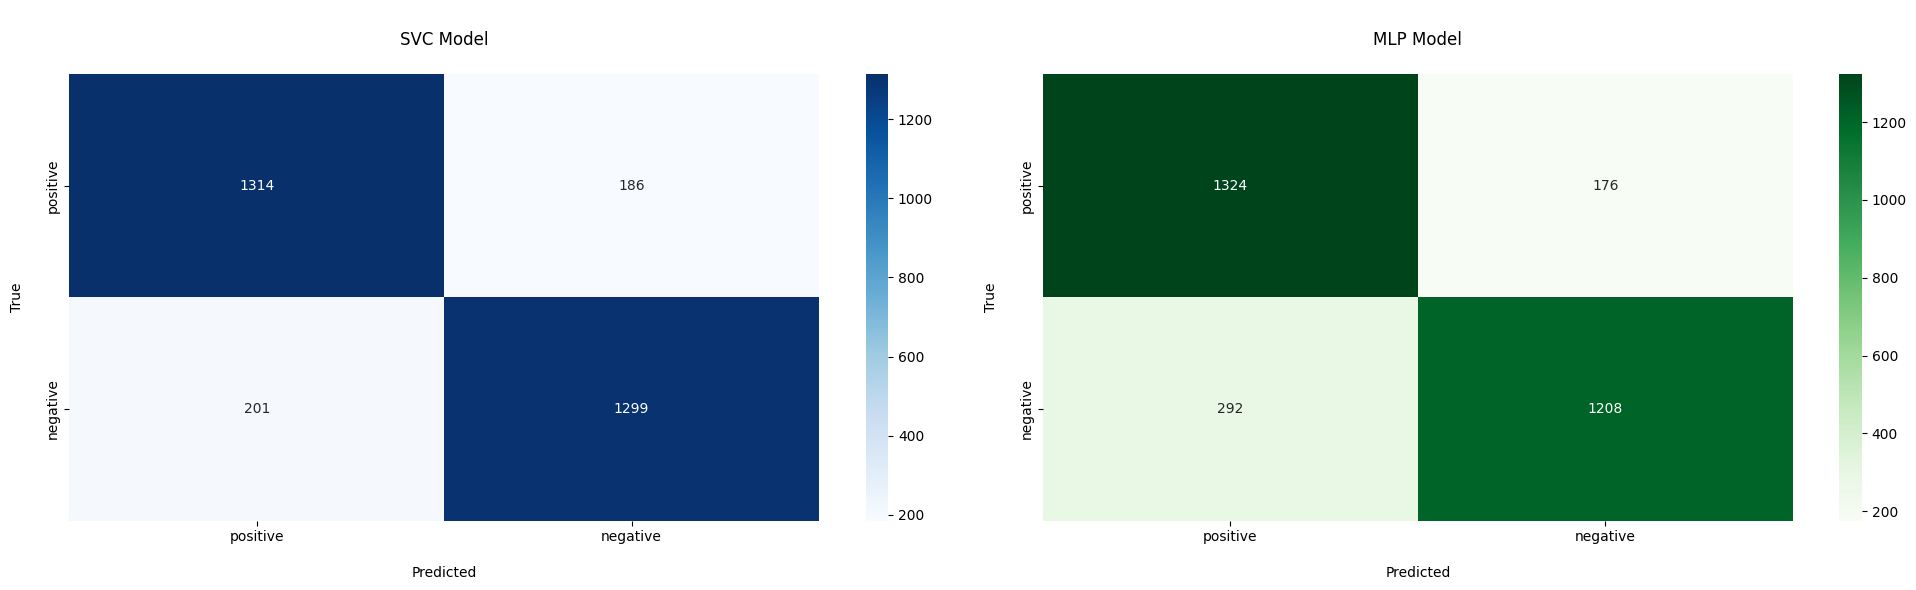

In [ ]:
# create confusion matrices
con_matrix_svc_base = confusion_matrix(y_test, y_pred_svc_base)
con_matrix_mlp_base = confusion_matrix(y_test, y_pred_mlp_eval)

# plot combined confusion matrices to compare the results
create_combined_confusion_matrix_plots(
  [con_matrix_svc_base, con_matrix_mlp_base],
  ["SVC Model", "MLP Model"],
  ["Blues", "Greens"],
  20
)

# 5. References
Stack Overflow (2023) *How can I get 1000 sample from each class of dataframe?*. Available at: https://stackoverflow.com/questions/77369695/how-can-i-get-1000-sample-from-each-class-of-dataframe (Accessed: 2 November 2025)

Mhaske, P. (2025) *A Comprehensive Guide to Doc2Vec: Document Embeddings*. Available at: https://mhaske-padmajeet.medium.com/a-comprehensive-guide-to-doc2vec-document-embeddings-fc408f0679f2 (Accessed: 6 November 2025)

GeeksforGeeks (2025) *Doc2Vec in NLP*. Available at: https://www.geeksforgeeks.org/nlp/doc2vec-in-nlp/ (Accessed: 13 November 2025)

Neri Van Otten (2023) *Practical Guide To Doc2Vec & How To Tutorial In Python*. Available at: https://spotintelligence.com/2023/09/06/doc2vec/ (Accessed: 13 November 2025)

MathWorks (no date) *What Is a Support Vector Machine?*. Available at: https://www.mathworks.com/discovery/support-vector-machine.html (Accessed: 16 November 2025)

Haj (2025) *When (and When Not) to Use SVMs*. Available at: https://medium.com/@haj122/when-and-when-not-to-use-svms-e9edea04d6ba (Accessed: 16 November 2025)

Jaiswal, S. (2025) *Multilayer Perceptrons in Machine Learning: A Comprehensive Guide*. Available at: https://www.datacamp.com/tutorial/multilayer-perceptrons-in-machine-learning (Accessed: 17 November 2025)

Hestisholihah (2023) *Hyperparameter Tuning Showdown: Grid Search vs. Random Search — Which is the Ultimate Winner?*. Available at: https://medium.com/@hestisholihah01/hyperparameter-tuning-showdown-grid-search-vs-random-search-which-is-the-ultimate-winner-5927b322e54d (Accessed: 18 November 2025)